# Common Task 1. Electron/photon classification

In [1]:
#@title Download the dataset
!wget -O photons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
!wget -O electrons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5

--2025-03-28 13:51:04--  https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.170.17, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photons.hdf5’

photons.hdf5        100%[===================>] 114.16M  20.6MB/s    in 6.9s    

2025-03-28 13:51:12 (16.4 MB/s) - ‘photons.hdf5’ saved [119703858/119703858]

--2025-03-28 13:51:13--  https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.170.17, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [applic

In [5]:
#@title Imports
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchsummary import summary

from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
#@title Set random seed

# For reproducibility, taken from Neuromatch Academy's Deep Learning course material
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

set_seed(seed=42)
gen = torch.Generator().manual_seed(42)

Random seed 42 has been set.


In [7]:
#@title Load the dataset
# The datasets fits into the RAM so I'll load them entirely
f = h5py.File('photons.hdf5', 'r')
p_x = f['X'][:]
p_y = f['y'][:]

f = h5py.File('electrons.hdf5', 'r')
e_x = f['X'][:]
e_y = f['y'][:]

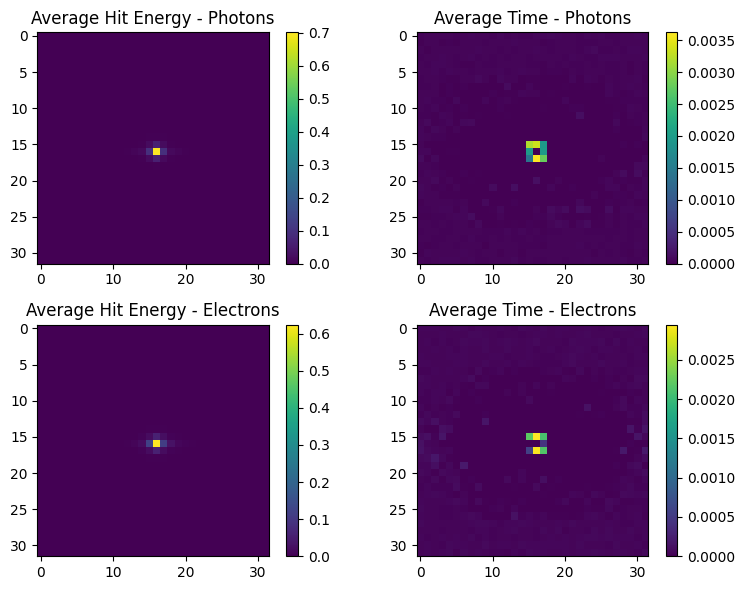

In [ ]:
#@title Visualizing the data

avg_p = np.mean(p_x, axis=0)
avg_p_energy, avg_p_time = avg_p[..., 0], avg_p[..., 1]

avg_e = np.mean(e_x, axis=0)
avg_e_energy, avg_e_time = avg_e[..., 0], avg_e[..., 1]

plt.figure(figsize=(8, 6))

# Photon Plots (Top Row)
plt.subplot(2, 2, 1)
plt.imshow(avg_p_energy, cmap='viridis', vmin=0, vmax=np.max(avg_p_energy))
plt.title('Average Hit Energy - Photons')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(avg_p_time, cmap='viridis', vmin=0, vmax=np.max(avg_p_time))
plt.title('Average Time - Photons')
plt.colorbar()

# Electron Plots (Bottom Row)
plt.subplot(2, 2, 3)
plt.imshow(avg_e_energy, cmap='viridis', vmin=0, vmax=np.max(avg_e_energy))
plt.title('Average Hit Energy - Electrons')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(avg_e_time, cmap='viridis', vmin=0, vmax=np.max(avg_e_time))
plt.title('Average Time - Electrons')
plt.colorbar()

plt.tight_layout()
plt.show()

## Preprocessing

In [8]:
# Combine data and create labels
X = np.concatenate([p_x, e_x], axis=0)
y = np.concatenate([p_y, e_y], axis=0)

del p_x, e_x, p_y, e_y

In [9]:
# Create dataset
X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
y = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X, y)

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1], generator=gen)

In [10]:
# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Architecture
The model architecture contains an initial 5x5 convolutional layer, 3 ResNet blocks, followed by a dropout layer and a fully-connected layer.

Since the data sample is only 32x32 size, I used 5x5 kernel for the initial convolutional layer instead of the standard 7x7 kernel size.



In [21]:
#@title ResNet
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.downsample = out_channels//in_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.downsample > 1:
            X = self.shortcut(X)

        Y = self.relu(Y + X)
        return Y

def block_layers(in_channels, out_channels, num_residuals):
    layers = []
    for _ in range(num_residuals):
        layers.append(BasicBlock(in_channels, out_channels))
    return nn.Sequential(*layers)

b1 = nn.Sequential(nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=1),
                   nn.BatchNorm2d(32),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2))

b2 = block_layers(32, 32, 2)
b3 = block_layers(32, 64, 1)
b4 = block_layers(64, 64, 2)

net = nn.Sequential(b1, b2, b3, b4,
                    nn.Dropout(0.5),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(64, 1))
model = net.to(device)
summary(model, (2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]           1,632
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 32, 15, 15]           9,248
       BatchNorm2d-6           [-1, 32, 15, 15]              64
              ReLU-7           [-1, 32, 15, 15]               0
            Conv2d-8           [-1, 32, 15, 15]           9,248
       BatchNorm2d-9           [-1, 32, 15, 15]              64
             ReLU-10           [-1, 32, 15, 15]               0
       BasicBlock-11           [-1, 32, 15, 15]               0
           Conv2d-12           [-1, 32, 15, 15]           9,248
      BatchNorm2d-13           [-1, 32, 15, 15]              64
             ReLU-14           [-1, 32,

## Training Setup



In [12]:
def evaluate(model, device, data_loader, show=True):
    test_loss, accuracy = 0.0, 0.0
    predictions, targets = [], []

    model.eval()
    with torch.no_grad():
      for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X).squeeze()
        test_loss += F.binary_cross_entropy_with_logits(logits, y).item()
        pred = logits.ge(0.).byte()
        accuracy += pred.eq(y.byte()).float().mean().item()

        y_pred = torch.sigmoid(logits)

        predictions.append(y_pred.tolist())
        targets.append(y.tolist())

    # Compute ROC score
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    fpr, tpr, _ = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    test_loss /= len(data_loader)
    accuracy /= len(data_loader)
    if show:
        print(f'Test set: Average loss: {test_loss:.4f}\nAccuracy: {accuracy:.4f}\nROC AUC: {roc_auc:.4f}')
    return test_loss, accuracy, roc_auc, fpr, tpr

In [17]:
def train(model, device, data_loader, val_loader, num_epochs):
    train_loss, train_acc = [], []
    val_loss, val_acc, roc_scores = [], [], []

    for epoch in range(1, num_epochs+1):
      print(f"Epoch {epoch}/{num_epochs}")

      epoch_loss, epoch_acc = 0, 0
      model.train()
      for data in tqdm(data_loader, total=len(data_loader)):
          X, y = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
          y_pred = model(X).squeeze()
          loss = F.binary_cross_entropy_with_logits(y_pred, y)
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

          pred = y_pred.ge(0.).byte()
          acc = pred.eq(y.byte()).float().mean()
          epoch_acc += acc.item()

      train_loss.append(epoch_loss/len(data_loader))
      train_acc.append(epoch_acc/len(data_loader))
      print('Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}'.format(epoch, train_loss[epoch-1], train_acc[epoch-1]))

      # Validation
      val_loss_epoch, val_acc_epoch, roc_score, _, _ = evaluate(model, device, val_loader, show=False)
      val_loss.append(val_loss_epoch)
      val_acc.append(val_acc_epoch)
      roc_scores.append(roc_score)
      print('Epoch: {}, Val loss: {:.4f}, Val accuracy: {:.4f}'.format(epoch, val_loss[epoch-1], val_acc[epoch-1]))

      scheduler.step(val_loss_epoch)

      if epoch % 10 == 0:
        torch.save(model.state_dict(), f"resnet15_particle_classifier_{epoch}.pth")

    return train_loss, train_acc, val_loss, val_acc, roc_scores

In [22]:
# Initialize
lr = 1e-3
weight_decay = 1e-4

model = net.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

## Training Loop

In [23]:
train_loss, train_acc, val_loss, val_acc, roc_scores = train(model, device, data_loader=train_loader, val_loader=val_loader, num_epochs=100)

Epoch 1/100


100%|██████████| 5447/5447 [00:48<00:00, 111.52it/s]


Epoch: 1, Train loss: 0.6284, Train accuracy: 0.6497
Epoch: 1, Val loss: 0.6020, Val accuracy: 0.6861
Epoch 2/100


100%|██████████| 5447/5447 [00:49<00:00, 110.93it/s]


Epoch: 2, Train loss: 0.5864, Train accuracy: 0.6978
Epoch: 2, Val loss: 0.5938, Val accuracy: 0.6909
Epoch 3/100


100%|██████████| 5447/5447 [00:48<00:00, 112.32it/s]


Epoch: 3, Train loss: 0.5763, Train accuracy: 0.7068
Epoch: 3, Val loss: 0.5654, Val accuracy: 0.7155
Epoch 4/100


100%|██████████| 5447/5447 [00:48<00:00, 112.52it/s]


Epoch: 4, Train loss: 0.5707, Train accuracy: 0.7110
Epoch: 4, Val loss: 0.5701, Val accuracy: 0.7124
Epoch 5/100


100%|██████████| 5447/5447 [00:48<00:00, 112.56it/s]


Epoch: 5, Train loss: 0.5676, Train accuracy: 0.7142
Epoch: 5, Val loss: 0.6401, Val accuracy: 0.6224
Epoch 6/100


100%|██████████| 5447/5447 [00:48<00:00, 112.09it/s]


Epoch: 6, Train loss: 0.5652, Train accuracy: 0.7154
Epoch: 6, Val loss: 0.7272, Val accuracy: 0.5397
Epoch 7/100


100%|██████████| 5447/5447 [00:48<00:00, 111.87it/s]


Epoch: 7, Train loss: 0.5638, Train accuracy: 0.7163
Epoch: 7, Val loss: 0.5636, Val accuracy: 0.7174
Epoch 8/100


100%|██████████| 5447/5447 [00:48<00:00, 111.81it/s]


Epoch: 8, Train loss: 0.5623, Train accuracy: 0.7176
Epoch: 8, Val loss: 0.5617, Val accuracy: 0.7170
Epoch 9/100


100%|██████████| 5447/5447 [00:48<00:00, 112.27it/s]


Epoch: 9, Train loss: 0.5614, Train accuracy: 0.7178
Epoch: 9, Val loss: 0.5689, Val accuracy: 0.7119
Epoch 10/100


100%|██████████| 5447/5447 [00:48<00:00, 112.46it/s]


Epoch: 10, Train loss: 0.5603, Train accuracy: 0.7194
Epoch: 10, Val loss: 0.6007, Val accuracy: 0.6807
Epoch 11/100


100%|██████████| 5447/5447 [00:48<00:00, 113.02it/s]


Epoch: 11, Train loss: 0.5593, Train accuracy: 0.7199
Epoch: 11, Val loss: 0.5552, Val accuracy: 0.7213
Epoch 12/100


100%|██████████| 5447/5447 [00:48<00:00, 112.57it/s]


Epoch: 12, Train loss: 0.5585, Train accuracy: 0.7207
Epoch: 12, Val loss: 0.5561, Val accuracy: 0.7231
Epoch 13/100


100%|██████████| 5447/5447 [00:48<00:00, 111.93it/s]


Epoch: 13, Train loss: 0.5581, Train accuracy: 0.7210
Epoch: 13, Val loss: 0.5603, Val accuracy: 0.7195
Epoch 14/100


100%|██████████| 5447/5447 [00:48<00:00, 112.18it/s]


Epoch: 14, Train loss: 0.5577, Train accuracy: 0.7214
Epoch: 14, Val loss: 0.5576, Val accuracy: 0.7208
Epoch 15/100


100%|██████████| 5447/5447 [00:48<00:00, 112.67it/s]


Epoch: 15, Train loss: 0.5573, Train accuracy: 0.7221
Epoch: 15, Val loss: 0.5686, Val accuracy: 0.7137
Epoch 16/100


100%|██████████| 5447/5447 [00:48<00:00, 112.44it/s]


Epoch: 16, Train loss: 0.5472, Train accuracy: 0.7287
Epoch: 16, Val loss: 0.5446, Val accuracy: 0.7309
Epoch 17/100


100%|██████████| 5447/5447 [00:48<00:00, 112.43it/s]


Epoch: 17, Train loss: 0.5447, Train accuracy: 0.7303
Epoch: 17, Val loss: 0.5432, Val accuracy: 0.7312
Epoch 18/100


100%|██████████| 5447/5447 [00:48<00:00, 111.75it/s]


Epoch: 18, Train loss: 0.5438, Train accuracy: 0.7313
Epoch: 18, Val loss: 0.5426, Val accuracy: 0.7315
Epoch 19/100


100%|██████████| 5447/5447 [00:48<00:00, 112.15it/s]


Epoch: 19, Train loss: 0.5428, Train accuracy: 0.7319
Epoch: 19, Val loss: 0.5427, Val accuracy: 0.7318
Epoch 20/100


100%|██████████| 5447/5447 [00:48<00:00, 112.17it/s]


Epoch: 20, Train loss: 0.5425, Train accuracy: 0.7320
Epoch: 20, Val loss: 0.5422, Val accuracy: 0.7328
Epoch 21/100


100%|██████████| 5447/5447 [00:48<00:00, 112.41it/s]


Epoch: 21, Train loss: 0.5420, Train accuracy: 0.7323
Epoch: 21, Val loss: 0.5422, Val accuracy: 0.7328
Epoch 22/100


100%|██████████| 5447/5447 [00:48<00:00, 112.10it/s]


Epoch: 22, Train loss: 0.5413, Train accuracy: 0.7331
Epoch: 22, Val loss: 0.5434, Val accuracy: 0.7325
Epoch 23/100


100%|██████████| 5447/5447 [00:48<00:00, 112.69it/s]


Epoch: 23, Train loss: 0.5408, Train accuracy: 0.7338
Epoch: 23, Val loss: 0.5411, Val accuracy: 0.7330
Epoch 24/100


100%|██████████| 5447/5447 [00:48<00:00, 112.87it/s]


Epoch: 24, Train loss: 0.5408, Train accuracy: 0.7335
Epoch: 24, Val loss: 0.5418, Val accuracy: 0.7339
Epoch 25/100


100%|██████████| 5447/5447 [00:48<00:00, 112.92it/s]


Epoch: 25, Train loss: 0.5403, Train accuracy: 0.7339
Epoch: 25, Val loss: 0.5413, Val accuracy: 0.7323
Epoch 26/100


100%|██████████| 5447/5447 [00:48<00:00, 112.82it/s]


Epoch: 26, Train loss: 0.5397, Train accuracy: 0.7339
Epoch: 26, Val loss: 0.5405, Val accuracy: 0.7341
Epoch 27/100


100%|██████████| 5447/5447 [00:48<00:00, 112.60it/s]


Epoch: 27, Train loss: 0.5398, Train accuracy: 0.7336
Epoch: 27, Val loss: 0.5409, Val accuracy: 0.7332
Epoch 28/100


100%|██████████| 5447/5447 [00:48<00:00, 111.70it/s]


Epoch: 28, Train loss: 0.5393, Train accuracy: 0.7338
Epoch: 28, Val loss: 0.5419, Val accuracy: 0.7333
Epoch 29/100


100%|██████████| 5447/5447 [00:48<00:00, 111.32it/s]


Epoch: 29, Train loss: 0.5390, Train accuracy: 0.7343
Epoch: 29, Val loss: 0.5401, Val accuracy: 0.7346
Epoch 30/100


100%|██████████| 5447/5447 [00:48<00:00, 112.54it/s]


Epoch: 30, Train loss: 0.5386, Train accuracy: 0.7347
Epoch: 30, Val loss: 0.5404, Val accuracy: 0.7333
Epoch 31/100


100%|██████████| 5447/5447 [00:48<00:00, 112.65it/s]


Epoch: 31, Train loss: 0.5383, Train accuracy: 0.7345
Epoch: 31, Val loss: 0.5398, Val accuracy: 0.7340
Epoch 32/100


100%|██████████| 5447/5447 [00:48<00:00, 112.78it/s]


Epoch: 32, Train loss: 0.5380, Train accuracy: 0.7356
Epoch: 32, Val loss: 0.5398, Val accuracy: 0.7339
Epoch 33/100


100%|██████████| 5447/5447 [00:48<00:00, 112.77it/s]


Epoch: 33, Train loss: 0.5376, Train accuracy: 0.7356
Epoch: 33, Val loss: 0.5397, Val accuracy: 0.7339
Epoch 34/100


100%|██████████| 5447/5447 [00:48<00:00, 112.89it/s]


Epoch: 34, Train loss: 0.5373, Train accuracy: 0.7351
Epoch: 34, Val loss: 0.5435, Val accuracy: 0.7320
Epoch 35/100


100%|██████████| 5447/5447 [00:48<00:00, 111.21it/s]


Epoch: 35, Train loss: 0.5373, Train accuracy: 0.7353
Epoch: 35, Val loss: 0.5393, Val accuracy: 0.7340
Epoch 36/100


100%|██████████| 5447/5447 [00:49<00:00, 109.07it/s]


Epoch: 36, Train loss: 0.5368, Train accuracy: 0.7358
Epoch: 36, Val loss: 0.5398, Val accuracy: 0.7344
Epoch 37/100


100%|██████████| 5447/5447 [00:49<00:00, 110.90it/s]


Epoch: 37, Train loss: 0.5367, Train accuracy: 0.7357
Epoch: 37, Val loss: 0.5399, Val accuracy: 0.7344
Epoch 38/100


100%|██████████| 5447/5447 [00:49<00:00, 110.44it/s]


Epoch: 38, Train loss: 0.5366, Train accuracy: 0.7357
Epoch: 38, Val loss: 0.5406, Val accuracy: 0.7332
Epoch 39/100


100%|██████████| 5447/5447 [00:48<00:00, 111.47it/s]


Epoch: 39, Train loss: 0.5361, Train accuracy: 0.7358
Epoch: 39, Val loss: 0.5396, Val accuracy: 0.7345
Epoch 40/100


100%|██████████| 5447/5447 [00:48<00:00, 111.49it/s]


Epoch: 40, Train loss: 0.5336, Train accuracy: 0.7375
Epoch: 40, Val loss: 0.5382, Val accuracy: 0.7346
Epoch 41/100


100%|██████████| 5447/5447 [00:48<00:00, 111.26it/s]


Epoch: 41, Train loss: 0.5328, Train accuracy: 0.7382
Epoch: 41, Val loss: 0.5384, Val accuracy: 0.7350
Epoch 42/100


100%|██████████| 5447/5447 [00:49<00:00, 109.48it/s]


Epoch: 42, Train loss: 0.5331, Train accuracy: 0.7381
Epoch: 42, Val loss: 0.5381, Val accuracy: 0.7350
Epoch 43/100


100%|██████████| 5447/5447 [00:49<00:00, 110.45it/s]


Epoch: 43, Train loss: 0.5325, Train accuracy: 0.7382
Epoch: 43, Val loss: 0.5385, Val accuracy: 0.7349
Epoch 44/100


100%|██████████| 5447/5447 [00:48<00:00, 111.66it/s]


Epoch: 44, Train loss: 0.5328, Train accuracy: 0.7382
Epoch: 44, Val loss: 0.5385, Val accuracy: 0.7347
Epoch 45/100


100%|██████████| 5447/5447 [00:48<00:00, 112.29it/s]


Epoch: 45, Train loss: 0.5326, Train accuracy: 0.7383
Epoch: 45, Val loss: 0.5383, Val accuracy: 0.7345
Epoch 46/100


100%|██████████| 5447/5447 [00:48<00:00, 111.97it/s]


Epoch: 46, Train loss: 0.5323, Train accuracy: 0.7383
Epoch: 46, Val loss: 0.5388, Val accuracy: 0.7348
Epoch 47/100


100%|██████████| 5447/5447 [00:48<00:00, 111.24it/s]


Epoch: 47, Train loss: 0.5320, Train accuracy: 0.7383
Epoch: 47, Val loss: 0.5382, Val accuracy: 0.7346
Epoch 48/100


100%|██████████| 5447/5447 [00:48<00:00, 111.40it/s]


Epoch: 48, Train loss: 0.5320, Train accuracy: 0.7383
Epoch: 48, Val loss: 0.5384, Val accuracy: 0.7345
Epoch 49/100


100%|██████████| 5447/5447 [00:48<00:00, 111.67it/s]


Epoch: 49, Train loss: 0.5319, Train accuracy: 0.7388
Epoch: 49, Val loss: 0.5384, Val accuracy: 0.7345
Epoch 50/100


100%|██████████| 5447/5447 [00:49<00:00, 110.52it/s]


Epoch: 50, Train loss: 0.5317, Train accuracy: 0.7388
Epoch: 50, Val loss: 0.5384, Val accuracy: 0.7348
Epoch 51/100


100%|██████████| 5447/5447 [00:48<00:00, 111.32it/s]


Epoch: 51, Train loss: 0.5318, Train accuracy: 0.7388
Epoch: 51, Val loss: 0.5386, Val accuracy: 0.7347
Epoch 52/100


100%|██████████| 5447/5447 [00:48<00:00, 111.26it/s]


Epoch: 52, Train loss: 0.5316, Train accuracy: 0.7388
Epoch: 52, Val loss: 0.5382, Val accuracy: 0.7348
Epoch 53/100


100%|██████████| 5447/5447 [00:48<00:00, 111.71it/s]


Epoch: 53, Train loss: 0.5317, Train accuracy: 0.7388
Epoch: 53, Val loss: 0.5383, Val accuracy: 0.7346
Epoch 54/100


100%|██████████| 5447/5447 [00:48<00:00, 111.88it/s]


Epoch: 54, Train loss: 0.5318, Train accuracy: 0.7387
Epoch: 54, Val loss: 0.5387, Val accuracy: 0.7348
Epoch 55/100


100%|██████████| 5447/5447 [00:48<00:00, 112.04it/s]


Epoch: 55, Train loss: 0.5317, Train accuracy: 0.7384
Epoch: 55, Val loss: 0.5384, Val accuracy: 0.7345
Epoch 56/100


100%|██████████| 5447/5447 [00:48<00:00, 112.08it/s]


Epoch: 56, Train loss: 0.5317, Train accuracy: 0.7388
Epoch: 56, Val loss: 0.5385, Val accuracy: 0.7346
Epoch 57/100


100%|██████████| 5447/5447 [00:48<00:00, 111.87it/s]


Epoch: 57, Train loss: 0.5319, Train accuracy: 0.7389
Epoch: 57, Val loss: 0.5383, Val accuracy: 0.7344
Epoch 58/100


100%|██████████| 5447/5447 [00:48<00:00, 111.84it/s]


Epoch: 58, Train loss: 0.5318, Train accuracy: 0.7389
Epoch: 58, Val loss: 0.5388, Val accuracy: 0.7344
Epoch 59/100


100%|██████████| 5447/5447 [00:48<00:00, 112.26it/s]


Epoch: 59, Train loss: 0.5315, Train accuracy: 0.7386
Epoch: 59, Val loss: 0.5383, Val accuracy: 0.7344
Epoch 60/100


100%|██████████| 5447/5447 [00:48<00:00, 112.20it/s]


Epoch: 60, Train loss: 0.5319, Train accuracy: 0.7385
Epoch: 60, Val loss: 0.5383, Val accuracy: 0.7345
Epoch 61/100


100%|██████████| 5447/5447 [00:48<00:00, 111.63it/s]


Epoch: 61, Train loss: 0.5318, Train accuracy: 0.7385
Epoch: 61, Val loss: 0.5382, Val accuracy: 0.7344
Epoch 62/100


100%|██████████| 5447/5447 [00:48<00:00, 111.82it/s]


Epoch: 62, Train loss: 0.5316, Train accuracy: 0.7390
Epoch: 62, Val loss: 0.5383, Val accuracy: 0.7344
Epoch 63/100


100%|██████████| 5447/5447 [00:48<00:00, 112.09it/s]


Epoch: 63, Train loss: 0.5319, Train accuracy: 0.7388
Epoch: 63, Val loss: 0.5385, Val accuracy: 0.7346
Epoch 64/100


100%|██████████| 5447/5447 [00:48<00:00, 111.92it/s]


Epoch: 64, Train loss: 0.5319, Train accuracy: 0.7384
Epoch: 64, Val loss: 0.5382, Val accuracy: 0.7349
Epoch 65/100


100%|██████████| 5447/5447 [00:48<00:00, 111.91it/s]


Epoch: 65, Train loss: 0.5318, Train accuracy: 0.7383
Epoch: 65, Val loss: 0.5383, Val accuracy: 0.7346
Epoch 66/100


100%|██████████| 5447/5447 [00:48<00:00, 111.52it/s]


Epoch: 66, Train loss: 0.5319, Train accuracy: 0.7385
Epoch: 66, Val loss: 0.5382, Val accuracy: 0.7345
Epoch 67/100


100%|██████████| 5447/5447 [00:49<00:00, 111.01it/s]


Epoch: 67, Train loss: 0.5316, Train accuracy: 0.7389
Epoch: 67, Val loss: 0.5383, Val accuracy: 0.7346
Epoch 68/100


100%|██████████| 5447/5447 [00:48<00:00, 111.27it/s]


Epoch: 68, Train loss: 0.5317, Train accuracy: 0.7386
Epoch: 68, Val loss: 0.5384, Val accuracy: 0.7344
Epoch 69/100


100%|██████████| 5447/5447 [00:49<00:00, 110.12it/s]


Epoch: 69, Train loss: 0.5318, Train accuracy: 0.7383
Epoch: 69, Val loss: 0.5385, Val accuracy: 0.7345
Epoch 70/100


100%|██████████| 5447/5447 [00:50<00:00, 107.22it/s]


Epoch: 70, Train loss: 0.5318, Train accuracy: 0.7388
Epoch: 70, Val loss: 0.5384, Val accuracy: 0.7345
Epoch 71/100


100%|██████████| 5447/5447 [00:49<00:00, 108.96it/s]


Epoch: 71, Train loss: 0.5316, Train accuracy: 0.7388
Epoch: 71, Val loss: 0.5385, Val accuracy: 0.7345
Epoch 72/100


100%|██████████| 5447/5447 [00:50<00:00, 108.28it/s]


Epoch: 72, Train loss: 0.5320, Train accuracy: 0.7385
Epoch: 72, Val loss: 0.5383, Val accuracy: 0.7344
Epoch 73/100


100%|██████████| 5447/5447 [00:50<00:00, 108.87it/s]


Epoch: 73, Train loss: 0.5316, Train accuracy: 0.7384
Epoch: 73, Val loss: 0.5389, Val accuracy: 0.7344
Epoch 74/100


100%|██████████| 5447/5447 [00:48<00:00, 111.30it/s]


Epoch: 74, Train loss: 0.5317, Train accuracy: 0.7387
Epoch: 74, Val loss: 0.5384, Val accuracy: 0.7344
Epoch 75/100


100%|██████████| 5447/5447 [00:48<00:00, 111.65it/s]


Epoch: 75, Train loss: 0.5319, Train accuracy: 0.7385
Epoch: 75, Val loss: 0.5386, Val accuracy: 0.7348
Epoch 76/100


100%|██████████| 5447/5447 [00:48<00:00, 112.52it/s]


Epoch: 76, Train loss: 0.5320, Train accuracy: 0.7389
Epoch: 76, Val loss: 0.5386, Val accuracy: 0.7347
Epoch 77/100


100%|██████████| 5447/5447 [00:48<00:00, 112.57it/s]


Epoch: 77, Train loss: 0.5319, Train accuracy: 0.7387
Epoch: 77, Val loss: 0.5384, Val accuracy: 0.7344
Epoch 78/100


100%|██████████| 5447/5447 [00:48<00:00, 112.51it/s]


Epoch: 78, Train loss: 0.5315, Train accuracy: 0.7390
Epoch: 78, Val loss: 0.5383, Val accuracy: 0.7344
Epoch 79/100


100%|██████████| 5447/5447 [00:48<00:00, 112.36it/s]


Epoch: 79, Train loss: 0.5318, Train accuracy: 0.7385
Epoch: 79, Val loss: 0.5382, Val accuracy: 0.7345
Epoch 80/100


100%|██████████| 5447/5447 [00:48<00:00, 112.03it/s]


Epoch: 80, Train loss: 0.5319, Train accuracy: 0.7385
Epoch: 80, Val loss: 0.5383, Val accuracy: 0.7344
Epoch 81/100


100%|██████████| 5447/5447 [00:48<00:00, 112.16it/s]


Epoch: 81, Train loss: 0.5319, Train accuracy: 0.7384
Epoch: 81, Val loss: 0.5384, Val accuracy: 0.7349
Epoch 82/100


100%|██████████| 5447/5447 [00:48<00:00, 112.29it/s]


Epoch: 82, Train loss: 0.5317, Train accuracy: 0.7392
Epoch: 82, Val loss: 0.5384, Val accuracy: 0.7345
Epoch 83/100


100%|██████████| 5447/5447 [00:48<00:00, 112.22it/s]


Epoch: 83, Train loss: 0.5319, Train accuracy: 0.7388
Epoch: 83, Val loss: 0.5383, Val accuracy: 0.7347
Epoch 84/100


100%|██████████| 5447/5447 [00:48<00:00, 112.49it/s]


Epoch: 84, Train loss: 0.5318, Train accuracy: 0.7385
Epoch: 84, Val loss: 0.5382, Val accuracy: 0.7345
Epoch 85/100


100%|██████████| 5447/5447 [00:48<00:00, 112.61it/s]


Epoch: 85, Train loss: 0.5318, Train accuracy: 0.7386
Epoch: 85, Val loss: 0.5382, Val accuracy: 0.7347
Epoch 86/100


100%|██████████| 5447/5447 [00:48<00:00, 111.19it/s]


Epoch: 86, Train loss: 0.5315, Train accuracy: 0.7386
Epoch: 86, Val loss: 0.5383, Val accuracy: 0.7347
Epoch 87/100


100%|██████████| 5447/5447 [00:48<00:00, 111.89it/s]


Epoch: 87, Train loss: 0.5317, Train accuracy: 0.7385
Epoch: 87, Val loss: 0.5386, Val accuracy: 0.7343
Epoch 88/100


100%|██████████| 5447/5447 [00:48<00:00, 111.30it/s]


Epoch: 88, Train loss: 0.5319, Train accuracy: 0.7391
Epoch: 88, Val loss: 0.5384, Val accuracy: 0.7345
Epoch 89/100


100%|██████████| 5447/5447 [00:48<00:00, 112.30it/s]


Epoch: 89, Train loss: 0.5319, Train accuracy: 0.7384
Epoch: 89, Val loss: 0.5383, Val accuracy: 0.7345
Epoch 90/100


100%|██████████| 5447/5447 [00:48<00:00, 111.84it/s]


Epoch: 90, Train loss: 0.5317, Train accuracy: 0.7391
Epoch: 90, Val loss: 0.5384, Val accuracy: 0.7348
Epoch 91/100


100%|██████████| 5447/5447 [00:48<00:00, 112.25it/s]


Epoch: 91, Train loss: 0.5316, Train accuracy: 0.7391
Epoch: 91, Val loss: 0.5386, Val accuracy: 0.7347
Epoch 92/100


100%|██████████| 5447/5447 [00:48<00:00, 111.83it/s]


Epoch: 92, Train loss: 0.5319, Train accuracy: 0.7389
Epoch: 92, Val loss: 0.5387, Val accuracy: 0.7344
Epoch 93/100


100%|██████████| 5447/5447 [00:48<00:00, 112.30it/s]


Epoch: 93, Train loss: 0.5319, Train accuracy: 0.7385
Epoch: 93, Val loss: 0.5383, Val accuracy: 0.7346
Epoch 94/100


100%|██████████| 5447/5447 [00:48<00:00, 111.78it/s]


Epoch: 94, Train loss: 0.5314, Train accuracy: 0.7392
Epoch: 94, Val loss: 0.5383, Val accuracy: 0.7342
Epoch 95/100


100%|██████████| 5447/5447 [00:48<00:00, 111.94it/s]


Epoch: 95, Train loss: 0.5318, Train accuracy: 0.7387
Epoch: 95, Val loss: 0.5383, Val accuracy: 0.7347
Epoch 96/100


100%|██████████| 5447/5447 [00:48<00:00, 112.30it/s]


Epoch: 96, Train loss: 0.5319, Train accuracy: 0.7381
Epoch: 96, Val loss: 0.5383, Val accuracy: 0.7348
Epoch 97/100


100%|██████████| 5447/5447 [00:48<00:00, 112.28it/s]


Epoch: 97, Train loss: 0.5317, Train accuracy: 0.7388
Epoch: 97, Val loss: 0.5382, Val accuracy: 0.7348
Epoch 98/100


100%|██████████| 5447/5447 [00:48<00:00, 111.97it/s]


Epoch: 98, Train loss: 0.5319, Train accuracy: 0.7385
Epoch: 98, Val loss: 0.5386, Val accuracy: 0.7346
Epoch 99/100


100%|██████████| 5447/5447 [00:48<00:00, 112.16it/s]


Epoch: 99, Train loss: 0.5319, Train accuracy: 0.7386
Epoch: 99, Val loss: 0.5383, Val accuracy: 0.7346
Epoch 100/100


100%|██████████| 5447/5447 [00:48<00:00, 111.88it/s]


Epoch: 100, Train loss: 0.5315, Train accuracy: 0.7388
Epoch: 100, Val loss: 0.5385, Val accuracy: 0.7348


In [32]:
test_loss, accuracy, roc_auc, fpr, tpr = evaluate(model, device, test_loader)

Test set: Average loss: 0.5379
Accuracy: 0.7362
ROC AUC: 0.8044


In [25]:
torch.save(model.state_dict(), "resnet15_particle_classifier.pth")

In [ ]:
# Initialize model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = net.to(device)
# model.load_state_dict(torch.load("resnet15_particle_classifier.pth", map_location=device))
# model.eval()

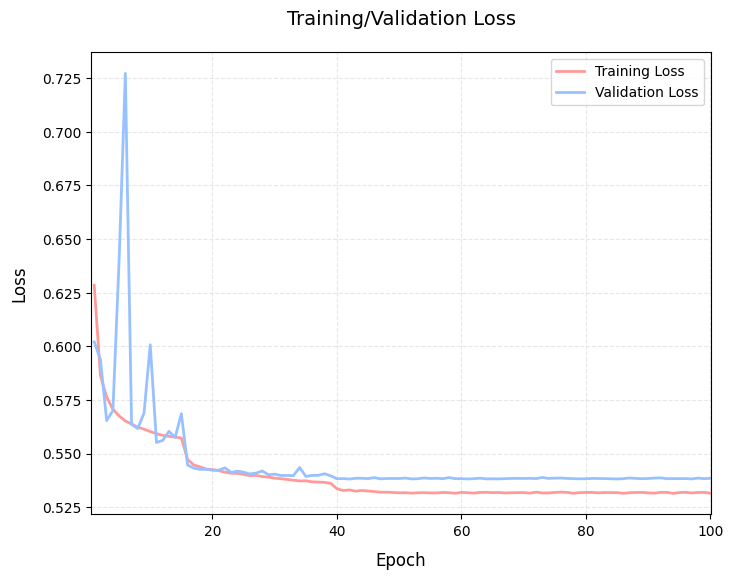

In [51]:
#@title Plot Loss curve
plt.figure(figsize=(8, 6))
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, color='#FF9A98', lw=2, label='Training Loss')
plt.plot(epochs, val_loss, color='#98C1FF', lw=2, label='Validation Loss')

# Styling
plt.title('Training/Validation Loss', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.xlim(0.5, len(epochs) + 0.1)
plt.legend(frameon=True, loc='upper right')
plt.grid(True, alpha=0.3, ls='--')

plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

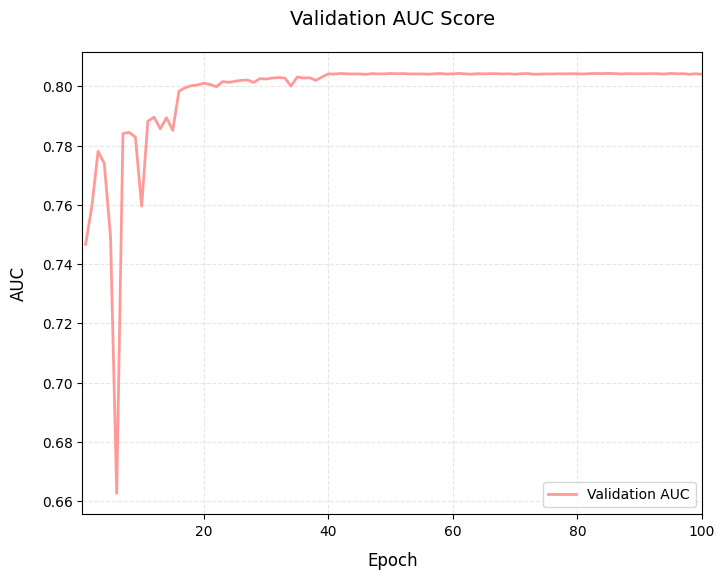

In [55]:
plt.figure(figsize=(8, 6))
epochs = range(1, len(roc_scores) + 1)

plt.plot(epochs, roc_scores, color='#FF9A98', lw=2, label='Validation AUC')

# Styling
plt.title('Validation AUC Score', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('AUC', fontsize=12, labelpad=10)
plt.xlim(0.5, len(epochs) + 0.1)
plt.legend(frameon=True, loc='lower right')
plt.grid(True, alpha=0.3, ls='--')

plt.savefig('auc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

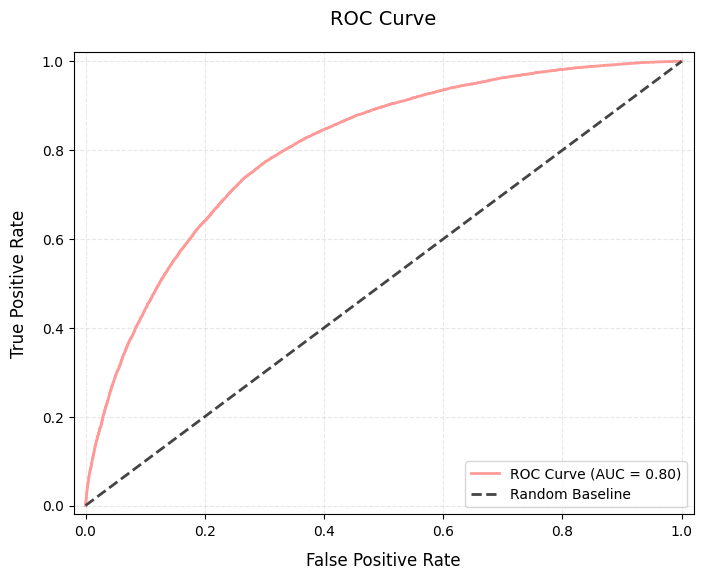

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#FF9A98', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#444444', ls='--', lw=2, label='Random Baseline')

# Style enhancements
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=12, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=12, labelpad=10)
plt.title('ROC Curve', fontsize=14, pad=20)
plt.legend(loc='lower right', frameon=True)
plt.grid(True, alpha=0.3, ls='--')

# Save and show
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluating the model on a sample


In [56]:
# Download the best model weights (~Epoch 30)
!gdown 1tV7p5oU6uDoWKYavzMcwqXrDxNtntSlH

Downloading...
From: https://drive.google.com/uc?id=1tV7p5oU6uDoWKYavzMcwqXrDxNtntSlH
To: /content/resnet15_particle_classifier_30.pth
100% 1.06M/1.06M [00:00<00:00, 9.12MB/s]


In [57]:
#@title ResNet
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.downsample = out_channels//in_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.downsample > 1:
            X = self.shortcut(X)

        Y = self.relu(Y + X)
        return Y

def block_layers(in_channels, out_channels, num_residuals):
    layers = []
    for _ in range(num_residuals):
        layers.append(BasicBlock(in_channels, out_channels))
    return nn.Sequential(*layers)

b1 = nn.Sequential(nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=1),
                   nn.BatchNorm2d(32),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2))

b2 = block_layers(32, 32, 2)
b3 = block_layers(32, 64, 1)
b4 = block_layers(64, 64, 2)

net = nn.Sequential(b1, b2, b3, b4,
                    nn.Dropout(0.5),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(64, 1))


In [58]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)

In [59]:
model.load_state_dict(torch.load("resnet15_particle_classifier_30.pth", map_location=device))
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [ ]:
inputs = torch.randn(1, 2, 32, 32).to(device)
with torch.no_grad():
  logits = model(inputs)
  y_pred = torch.sigmoid(logits).cpu().item()
y_pred

0.0